In [1]:
import re
import time
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import io
import requests
from mlxtend.plotting import plot_confusion_matrix

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from sklearn.linear_model import LogisticRegression
url="https://raw.githubusercontent.com/ankitmpatil/TweetSentimentForecasting/master/Tweets.csv"
s = requests.get(url).content
print(s)
df=pd.read_csv(io.StringIO(s.decode('utf-8')))
df

Using TensorFlow backend.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


In [2]:
#Data Preprocessing
#Checking number of null values in all the columns
#Getting an idea of the redundant columns to figure out which columns have the highest number of null values.
print("Number or Rows and Columns are",df.shape)
print("The number of nulls in each column are \n", df.isna().sum())

Number or Rows and Columns are (14640, 15)
The number of nulls in each column are 
 tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64


In [3]:
#Finding the percentage of nulls or NA values in each column
print("Percentage null or na values in df")
print(((df.isnull() | df.isna()).sum() * 100 / df.index.size).round(2))



#tweet_coord , airline_sentiment_gold, negativereason_gold have more than 90% missing data. It will be better to delete these columns as they will not provide any constructive information.
del df['tweet_coord']
del df['airline_sentiment_gold']
del df['negativereason_gold']
print(df.head())

Percentage null or na values in df
tweet_id                         0.00
airline_sentiment                0.00
airline_sentiment_confidence     0.00
negativereason                  37.31
negativereason_confidence       28.13
airline                          0.00
airline_sentiment_gold          99.73
name                             0.00
negativereason_gold             99.78
retweet_count                    0.00
text                             0.00
tweet_coord                     93.04
tweet_created                    0.00
tweet_location                  32.33
user_timezone                   32.92
dtype: float64
             tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074

Total number of tweets for each airline 
  airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline_sentiment, dtype: int64


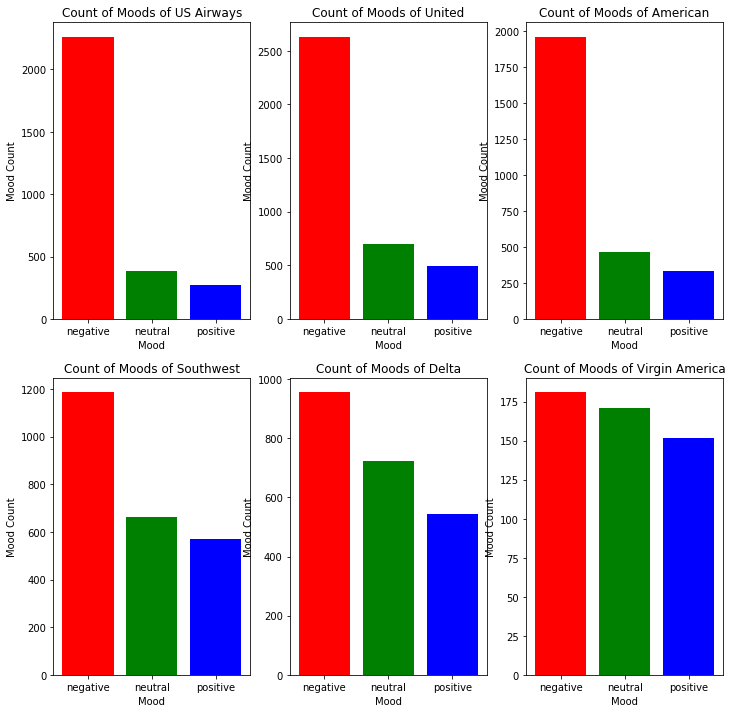

In [4]:

#Airline sentiments for each airline
#Calculating the total number of tweets for each airline
#Getting barplots for each airline with respect to sentiments of tweets (positive,negative or neutral), 
#to getclearer idea about the airline sentiments , airlines relationship.
print("Total number of tweets for each airline \n ",df.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False))
airlines= ['US Airways','United','American','Southwest','Delta','Virgin America']
plt.figure(1,figsize=(12, 12))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    new_df=df[df['airline']==i]
    count=new_df['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count, color=['red', 'green', 'blue'])
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Mood Count')
    plt.xlabel('Mood')
    plt.title('Count of Moods of '+i)
plt.show()
#United, US Airways, American substantially get negative reactions.
#Tweets for Virgin America are the most balanced.


In [5]:
#Most used words in Positive and Negative tweets
from wordcloud import WordCloud,STOPWORDS
#The goal is to firstly get an idea of the most frequent words in negative tweets.
#Get idea about most frequent words in positive tweets.


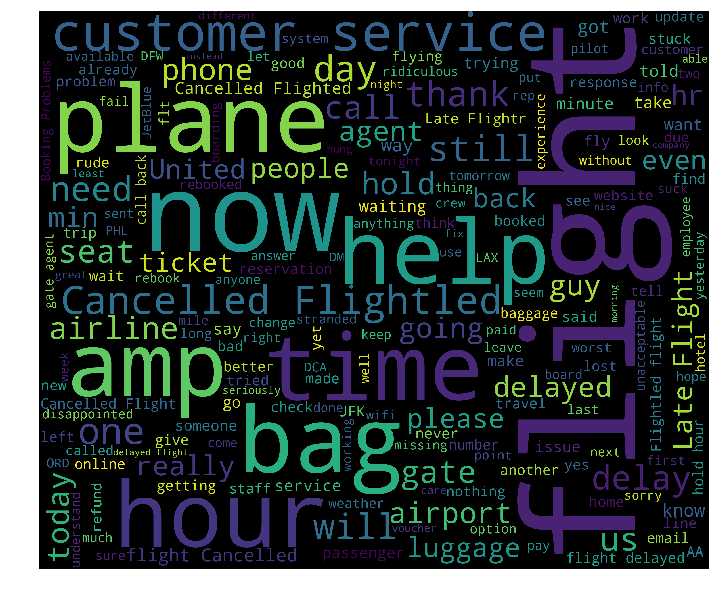

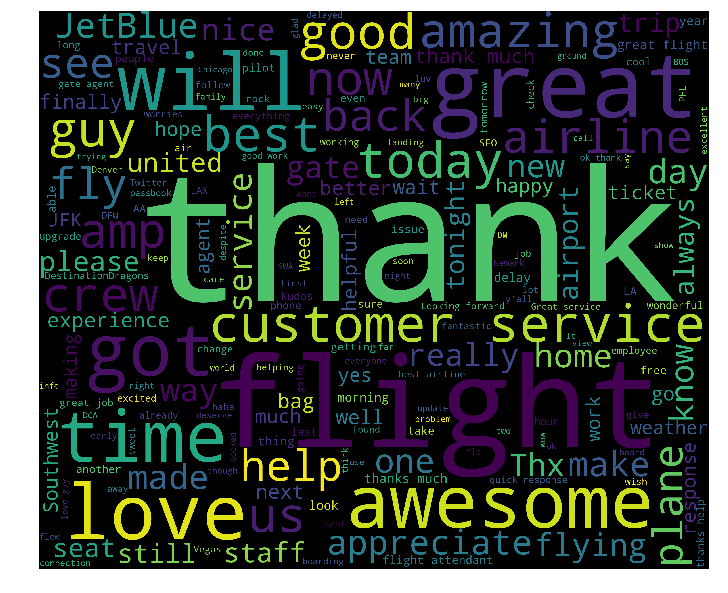

In [6]:
#Wordcloud for Negative sentiments of tweets
#Wordcloud is a great tool for visualizing nlp data. The larger the words in the wordcloud image , the more is the frequency of that word in our text data.
new_df=df[df['airline_sentiment']=='negative']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                        ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
#Wordcloud for positive reasons
#The code for getting positive sentiments is completely same with the one for negative sentiments. 
#Just replace negative with positive in the first line. Easy, right!
new_df=df[df['airline_sentiment']=='positive']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


In [7]:
# Calculating the highest frequency words in postive sentimental tweets
# Calculate highest frequency words in positive tweets
def freq(str): 
  
    # break the string into list of words  
    str = str.split()          
    str2 = [] 
  
    # loop till string values present in list str 
    for i in str:              
  
        # checking for the duplicacy 
        if i not in str2: 
  
            # insert value in str2 
            str2.append(i)  
              
    for i in range(0, len(str2)): 
        if(str.count(str2[i])>50): 
            print('Frequency of', str2[i], 'is :', str.count(str2[i]))

print(freq(cleaned_word))


#Words like Thanks, best, customer , love, flying , good are understandably present in the most frequent words of positive tweets.
#However, other than these, most of the words are stop words and need to be filtered. We will do so later.
#Lets try and visualize the reasons for negative tweets first !!

Frequency of to is : 923
Frequency of the is : 924
Frequency of time is : 59
Frequency of I is : 574
Frequency of fly is : 54
Frequency of this is : 143
Frequency of :) is : 96
Frequency of it is : 166
Frequency of was is : 226
Frequency of and is : 416
Frequency of an is : 74
Frequency of good is : 75
Frequency of so is : 163
Frequency of much is : 54
Frequency of is is : 219
Frequency of a is : 501
Frequency of great is : 144
Frequency of my is : 320
Frequency of &amp; is : 77
Frequency of on is : 327
Frequency of I'm is : 67
Frequency of flying is : 59
Frequency of your is : 212
Frequency of all is : 92
Frequency of from is : 124
Frequency of Thanks! is : 69
Frequency of for is : 658
Frequency of flight is : 263
Frequency of but is : 91
Frequency of you is : 509
Frequency of would is : 56
Frequency of be is : 135
Frequency of with is : 195
Frequency of you. is : 77
Frequency of love is : 85
Frequency of You is : 62
Frequency of are is : 120
Frequency of of is : 236
Frequency of that

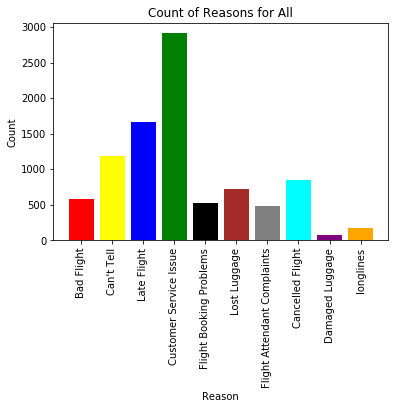

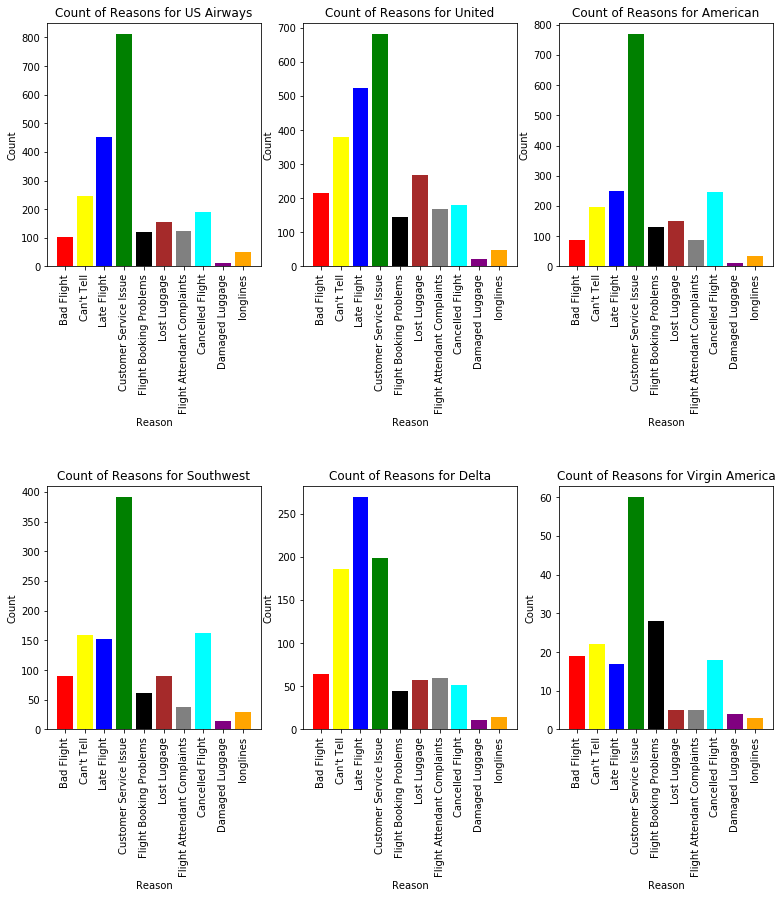

In [8]:
#What are the reasons for negative sentimental tweets for each airline ?

#Getting the number of negative reasons
df['negativereason'].nunique()
NR_Count=dict(df['negativereason'].value_counts(sort=False))
def NR_Count(Airline):
    if Airline=='All':
        a=df
    else:
        a=df[df['airline']==Airline]
    count=dict(a['negativereason'].value_counts())
    Unique_reason=list(df['negativereason'].unique())
    Unique_reason=[x for x in Unique_reason if str(x) != 'nan']
    Reason_frame=pd.DataFrame({'Reasons':Unique_reason})
    Reason_frame['count']=Reason_frame['Reasons'].apply(lambda x: count[x])
    return Reason_frame
def plot_reason(Airline):
    a=NR_Count(Airline)
    count=a['count']
    Index = range(1,(len(a)+1))
    plt.bar(Index,count, color=['red','yellow','blue','green','black','brown','gray','cyan','purple','orange'])
    plt.xticks(Index,a['Reasons'],rotation=90)
    plt.ylabel('Count')
    plt.xlabel('Reason')
    plt.title('Count of Reasons for '+Airline)
    
plot_reason('All')
plt.figure(2,figsize=(13, 13))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    plt.subplots_adjust(hspace=0.9)
    plot_reason(i)
plt.show()
#Customer Service Issue is the main negative reason for US Airways,United,American,Southwest,Virgin America
#Late Flight is the main negative reason for Delta
#Interestingly, Virgin America has the least count of negative reasons (all less than 60)
#Contrastingly to Virgin America, airlines like US Airways,United,American have more than 500 negative reasons (Late flight, Customer Service Issue)




In [9]:
#Is there a relationship between negative sentiments and date ?




#dataframe is from 2015-02-17 to 2015-02-24
#Visualizing if the date has any effect on the sentiments of the negative tweets.
#convert the Date column to pandas datetime
date = df.reset_index()
date.tweet_created = pd.to_datetime(date.tweet_created)

date.tweet_created = date.tweet_created.dt.date
date.tweet_created.head()
df = date
day_df = df.groupby(['tweet_created','airline','airline_sentiment']).size()
# day_df = day_df.reset_index()
print(day_df)
#It shows the sentiments of tweets for each date from 2015-02-17 to 2015-02-24 for every airline in our dataframe.


tweet_created  airline         airline_sentiment
2015-02-16     Delta           negative               1
                               neutral                1
               United          negative               2
2015-02-17     Delta           negative             108
                               neutral               86
                                                   ... 
2015-02-24     United          neutral               49
                               positive              25
               Virgin America  negative              10
                               neutral                6
                               positive              13
Length: 136, dtype: int64


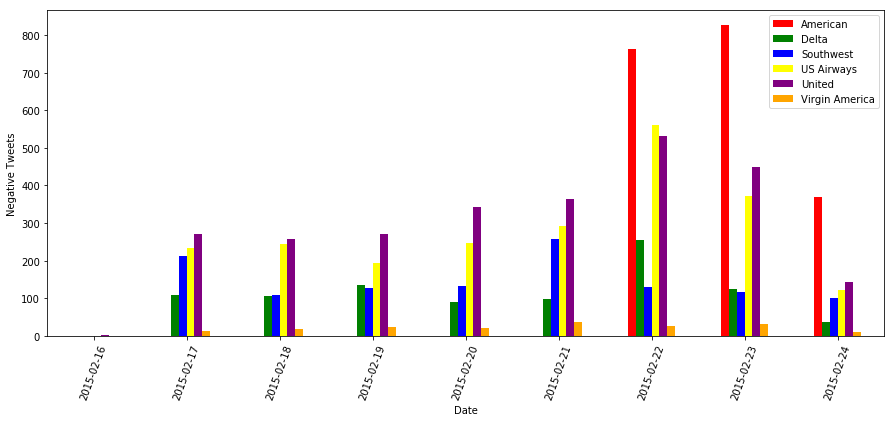

In [10]:
#Plotting this and get better visualization for negative tweets.
day_df = day_df.loc(axis=0)[:,:,'negative']
#groupby and plot data
ax2 = day_df.groupby(['tweet_created','airline']).sum().unstack().plot(kind = 'bar', color=['red', 'green', 'blue','yellow','purple','orange'], figsize = (15,6), rot = 70)
labels = ['American','Delta','Southwest','US Airways','United','Virgin America']
ax2.legend(labels = labels)
ax2.set_xlabel('Date')
ax2.set_ylabel('Negative Tweets')
plt.show()
#American has a sudden upsurge in negative sentimental tweets on 2015-02-23, which reduced to half the very next day 2015-02-24. (I hope American is doing better these days and resolved their Customer Service Issue as we saw before)
#Virgin America has the least number of negative tweets throughout the weekly data that we have. It should be noted that the total number of tweets for Virgin America was also significantly less as compared to the rest airlines, and hence the least negative tweets.
#The negative tweets for all the rest airlines is slightly skewed towards the end of the week !


In [11]:

#applying classification algorithms on it
def tweet_to_words(tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words )) 

df['clean_tweet']=df['text'].apply(lambda x: tweet_to_words(x))

In [24]:

# store tweets text in x & the target label in y
x=  df['text'].values
y= df['airline_sentiment'].values
#split data into training & test with 15%
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.15, random_state=42)

print("x_train:" ,x_train.shape, ", y_train: ", len(y_train))
print("x_test: ",x_test.shape, ", y_test: ", len(y_test))
print('training model (this could take sometime)...')

v = CountVectorizer(analyzer = "word")
train_features= v.fit_transform(x_train)
test_features=v.transform(x_test)

dense_features = train_features.toarray()
dense_test = test_features.toarray()

x_train: (12444,) , y_train:  12444
x_test:  (2196,) , y_test:  2196
training model (this could take sometime)...


Accuracy for DecisionTreeClassifier is 0.7085610200364298
              precision    recall  f1-score   support

    negative       0.83      0.81      0.82      1442
     neutral       0.46      0.49      0.47       413
    positive       0.55      0.55      0.55       341

    accuracy                           0.71      2196
   macro avg       0.61      0.62      0.61      2196
weighted avg       0.71      0.71      0.71      2196



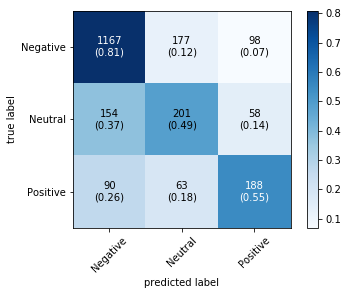

Accuracy for RandomForestClassifier is 0.7768670309653917
              precision    recall  f1-score   support

    negative       0.96      0.78      0.86      1728
     neutral       0.40      0.70      0.51       253
    positive       0.51      0.81      0.62       215

    accuracy                           0.78      2196
   macro avg       0.62      0.77      0.67      2196
weighted avg       0.85      0.78      0.80      2196



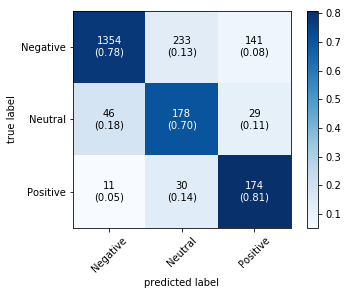

In [26]:
#Predicting sentiments from tweet text data
#Decision Tree Classifier
#Random Forest Classifier
Classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200)]

Accuracy=[]

Model=[]

for classifier in Classifiers:
    try:
        fit = classifier.fit(train_features,y_train)
        pred = fit.predict(test_features)
    except Exception:
        fit = classifier.fit(dense_features,y_train)
        pred = fit.predict(dense_test)
    accuracy = accuracy_score(pred,y_test)
    Accuracy.append(accuracy)
    Model.append(classifier.__class__.__name__)
    print('Accuracy for '+classifier.__class__.__name__+' is '+str(accuracy))
    print(classification_report(pred , y_test))
    #calculate the confusion matrix and plot it
    cm=confusion_matrix(pred , y_test)
    class_names =  ['Negative', 'Neutral', 'Positive']
    fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,
                                class_names=class_names)
    plt.show()

calculating results...
Logisitc regression Train accuracy is: 0.9535
Logisitc regression Test accuracy is: 0.8042
              precision    recall  f1-score   support

    negative       0.98      0.96      0.97      7931
     neutral       0.88      0.93      0.91      2522
    positive       0.93      0.95      0.94      1991

    accuracy                           0.95     12444
   macro avg       0.93      0.95      0.94     12444
weighted avg       0.95      0.95      0.95     12444



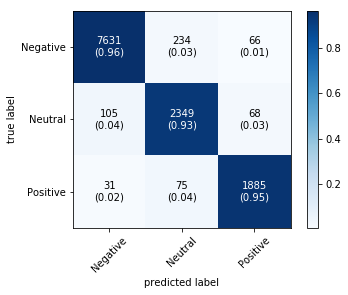

              precision    recall  f1-score   support

    negative       0.90      0.87      0.88      1456
     neutral       0.60      0.63      0.62       420
    positive       0.69      0.74      0.71       320

    accuracy                           0.80      2196
   macro avg       0.73      0.75      0.74      2196
weighted avg       0.81      0.80      0.81      2196



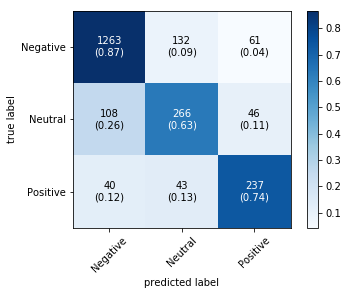

In [15]:
#Predicting sentiments from tweet text data
#Logistic Regression
clf = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=200)
clf.fit(dense_features, y_train)

print('calculating results...')

predictions_train = clf.predict(dense_features)
predictions_test = clf.predict(dense_test)

accuracy = accuracy_score(predictions_train,y_train)
print("Logisitc regression Train accuracy is: {:.4f}".format(accuracy))

accuracy = accuracy_score(predictions_test,y_test)
print("Logisitc regression Test accuracy is: {:.4f}".format(accuracy))

#For the Train Data
#print other performance measures, espically the data is unbalanced
print(classification_report(predictions_train , y_train))

#calculate the confusion matrix and plot it
cm1=confusion_matrix(predictions_train , y_train)
class_names =  ['Negative', 'Neutral', 'Positive']
fig, ax = plot_confusion_matrix(conf_mat=cm1,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,
                                class_names=class_names)
plt.show()


#For the Test Data
#print other performance measures, espically the data is unbalanced
print(classification_report(predictions_test , y_test))

#calculate the confusion matrix and plot it

cm=confusion_matrix(predictions_test , y_test)
class_names =  ['Negative', 'Neutral', 'Positive']
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,
                                class_names=class_names)
plt.show()
